# Monte Carlo
Monte Carlo(MC) methods are used to estimate state-action values in situations where complete knowledge of the environment is unavailable. These methods are much more scalable than dynamic programming as they require less space. MC can be used when a model is unavailable/unreachable by the learner. 

In [1]:
import torch
import matplotlib.pyplot as plt
import math
import gym

## Estimating the value of pi
Place a large number of random points in a square length 2 and count the number of points that land within a circle of unit radius. 
pi = 4 * points falling in side the circle/ total number of points  (3Blue1Brown for reference)


In [102]:
NUM_POINTS = 10000
points = torch.rand((NUM_POINTS, 2)) * 2 - 1            # Points made in the range (0, 2)
squared_dist = torch.pow(points, 2)
dist = squared_dist[:, 0] + squared_dist[:, 1]  # Euclidean distance squared (if num^2 <= 1, num <= 1)
dist = dist.numpy()
num_points_circle = (dist <= 1).sum()
print(num_points_circle)
points_circle = points[dist <= 1]
print(points_circle.shape)

7857
torch.Size([7857, 2])


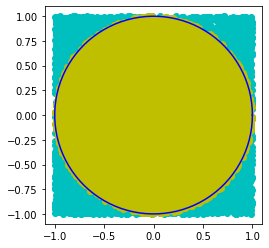

In [103]:
plt.axes().set_aspect('equal')

plt.scatter(points[:, 0].numpy(), points[:, 1].numpy(), c='c')
plt.scatter(points_circle[:, 0].numpy(), points_circle[:, 1].numpy(), c='y')
i = torch.linspace(0, 2 * math.pi)
plt.plot(torch.cos(i).numpy(), torch.sin(i).numpy(), c='b')
plt.show()

In [104]:
pi_estimate = 4 * num_points_circle / NUM_POINTS
print("Estimated value of pi: ", pi_estimate)

Estimated value of pi:  3.1428


## FrozenLake MC
Solving the FrozenLake problem with first-visit and every-visit Monte Carlo policy evaluation.

In [2]:
env = gym.make("FrozenLake-v0")

In [106]:
def run_episode(env, policy):
    state = env.reset()
    states, rewards, is_done = [state], [], False
    while not is_done:
        action = policy[state].item()
        state, reward, is_done, info = env.step(action)
        # All states and rewards recorded as the full environment is not accessible
        states.append(state)
        rewards.append(reward)  
    states = torch.tensor(states)
    rewards = torch.tensor(rewards)
    return states, rewards

In [107]:
def mc_prediction_first_visit(env, policy, gamma, num_episodes):
    num_states = policy.shape[0]
    V, N = torch.zeros(num_states), torch.zeros(num_states)
    for episode in range(num_episodes):
        states, rewards = run_episode(env, policy)
        first_visit, G = torch.zeros(num_states), torch.zeros(num_states)
        return_prob = 0
        # Skip initial state
        for state, reward in zip(reversed(states[1:]), reversed(rewards)):
             # First return (put in reverse otherwise rewards start at 0)
            return_prob = gamma * return_prob + reward            
            G[state] = return_prob
            first_visit[state] = 1   
        for state in states:
            if first_visit[state]:
                V[state] += G[state]
                N[state] += 1
    for state in range(num_states):
        if N[state] > 0:
            V[state] = V[state] / N[state]     # Averaging first returns
    return V

In [8]:
gamma = 1
num_episodes = 1000
# Optimal policy from DP solution
optimal_policy = torch.tensor([0., 3., 3., 3., 0., 3., 2., 3., 3., 1., 0., 3., 3., 2., 1., 3.])

In [109]:
mc_optimal_values = mc_prediction_first_visit(env, optimal_policy, gamma, num_episodes)
print("First visit MC values: \n", mc_optimal_values)

First visit MC values: 
 tensor([0.6463, 0.5061, 0.4280, 0.3914, 0.6467, 0.0000, 0.3616, 0.0000, 0.6588,
        0.6937, 0.6484, 0.0000, 0.0000, 0.7643, 0.8559, 1.0000])


In [10]:
def mc_prediction_every_visit(env, policy, gamma, num_episodes):
    num_states = policy.shape[0]
    V, N = torch.zeros(num_states), torch.zeros(num_states)
    G = torch.zeros(num_states)
    for episode in range(num_episodes):
        states, rewards = run_episode(env, policy)
        return_prob = 0
        # Skip initial state
        for state, reward in zip(reversed(states[1:]), reversed(rewards)):
             # Every return added
            return_prob = gamma * return_prob + reward            
            G[state] += return_prob
            N[state] += 1
    for state in range(num_states):
        if N[state] > 0:
            V[state] = G[state] / N[state]     # Averaging total returns
    return V

In [9]:
mc_optimal_values = mc_prediction_every_visit(env, optimal_policy, gamma, num_episodes)
print("Every visit MC values: \n", mc_optimal_values)

Every visit MC values: 
 tensor([0.6282, 0.4163, 0.3718, 0.3550, 0.6308, 0.0000, 0.3808, 0.0000, 0.6530,
        0.6947, 0.6525, 0.0000, 0.0000, 0.7802, 0.8799, 1.0000])


## Monte Carlo Blackjack
- Running policy evaluation on a Blackjack policy using Monte Carlo.
- Finding the optimal policy using on-policy and off-policy MC control.

In [2]:
from collections import defaultdict

In [5]:
env = gym.make("Blackjack-v0")

In [6]:
env.reset()               # (Player score, Dealer score, Whether the player has a usable ace)
# env.reset() changes initial scores and ace state

(16, 7, False)

In [7]:
env.step(1)                      # 1 card hit

((24, 7, False), -1.0, True, {})

In [8]:
env.step(0)                      # Reward goes to 1, hand > 21: reward = -1

((24, 7, False), -1.0, True, {})

In [7]:
def run_episode(env, hold_score):
    state = env.reset()
    rewards, states, is_done = [], [state], False
    while not is_done:
        action = 0 if state[0] >= hold_score else 1
        state, reward, is_done, info = env.step(action)
        states.append(state)
        rewards.append(reward)
    return states, rewards

### Value Estimation

In [8]:
def mc_prediction_first_visit(env, hold_score, gamma, num_episodes):
    V, N = defaultdict(float), defaultdict(int)
    for episode in range(num_episodes):
        states, rewards = run_episode(env, hold_score)
        return_prob = 0
        G = {}
        for state, reward in zip(states[1::-1], rewards[::-1]):
            return_prob = gamma * return_prob + reward
            G[state] = return_prob
        for state, return_prob in G.items():
            if state[0] <= 21:
                V[state] += return_prob
                N[state] += 1
    for state in V:
        V[state] /= N[state]
    return V

In [9]:
hold_score = 18
gamma = 1
num_episodes = 500000

In [ ]:
values = mc_prediction_first_visit(env, hold_score, gamma, num_episodes)
len(values)

In [166]:
from pprint import pprint
print("First visit MC calculated values:")
pprint(dict(values))

280

In [4]:
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [5]:
def plot_surface(x, y, z, title):
    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_subplot(111, projection="3d")
    surface = ax.plot_surface(x, y, z, rstride=1, cstride=1, cmap=matplotlib.cm.coolwarm, 
                              vmin=-1.0, vmax=1.0)
    ax.set_xlabel("Player Sum")
    ax.set_ylabel("Dealer showing")
    ax.set_zlabel("Value")
    ax.set_title(title)
    ax.view_init(ax.elev, 110)          # Set camera elevation
    fig.colorbar(surface)
    plt.show()


def plot_blackjack_values(V):
    player_sum = range(12, 22)
    dealer_values = range(1, 11)
    x, y = torch.meshgrid(torch.tensor(player_sum), torch.tensor(dealer_values))
    plot_values = torch.zeros((len(player_sum), len(dealer_values), 2))
    for i, player in enumerate(player_sum):
        for j, dealer in enumerate(dealer_values):
            for k, ace in enumerate([False, True]):
                plot_values[i, j, k] = V[player, dealer, ace]
    plot_values = plot_values.numpy()
    plot_surface(x, y, plot_values[:, :, 0], "Blackjack value function without a usable ace")
    plot_surface(x, y, plot_values[:, :, 1], "Blackjack value function with a usable ace")


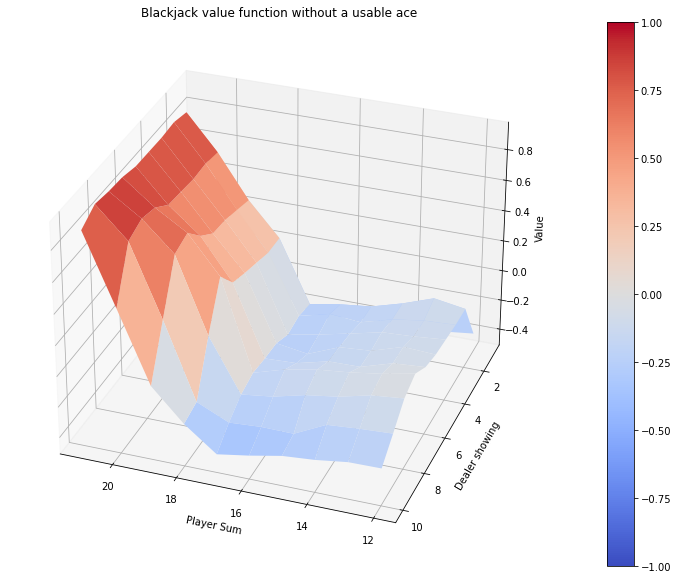

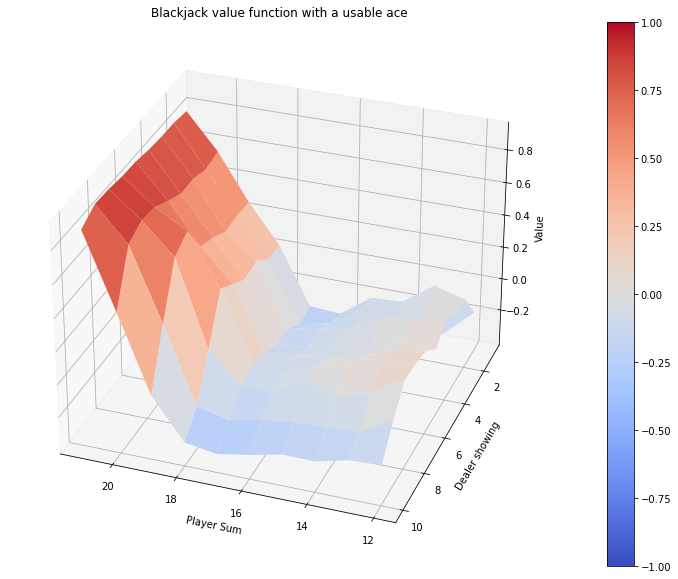

In [170]:
plot_blackjack_values(values)
# Higher the hold value, steeper the reward drop. 

### MC Control: on-policy

In [11]:
def run_episode(env, Q, num_actions):
    """
    env: OpenAI Gym environment
    Q: Action-value maatrix, a.k.a. Q-function
    num_actions: action space
    returns states, actions and rewards for the episode
    """
    state = env.reset()
    states, actions, rewards = [], [], []
    is_done = False
    action = torch.randint(low=0,high=num_actions, size=[1]).item()        # EXPLORING STARTS
    while not is_done:
        actions.append(action)
        states.append(state)
        state, reward, is_done, info = env.step(action)
        rewards.append(reward)
        action = torch.argmax(Q[state]).item()
    return states, actions, rewards

In [9]:
! pip install tqdm

In [12]:
from tqdm import tqdm 


def mc_control_on_policy(env, gamma, num_episodes):
    num_actions = env.action_space.n
    G_sum = defaultdict(float)
    N = defaultdict(int)
    Q = defaultdict(lambda: torch.zeros(num_actions))
    for episode in tqdm(range(num_episodes)):
        states, actions, rewards = run_episode(env, Q, num_actions)
        return_proba = 0
        G = {}
        for state, action, reward in zip(states[::-1], actions[::-1], rewards[::-1]):        # First visit MC policy value prediction
            return_proba = gamma * return_proba + reward
            G[(state, action)] = return_proba
        for (state, action), return_proba in G.items():                                      # Update Q function
            if state[0] <= 21:
                G_sum[(state, action)] += return_proba
                N[(state, action)] += 1
                Q[state][action] = G_sum[(state, action)] / N[(state, action)]
        policy = {}
        for state, actions in Q.items():                                                     # Making the policy greedy
            policy[state] = torch.argmax(actions).item()
    return Q, policy

In [13]:
gamma = 1
num_episodes = 50000

In [23]:
optimal_Q, optimal_policy = mc_control_on_policy(env, gamma, num_episodes)
# print(optimal_policy)

100%|██████████| 50000/50000 [02:44<00:00, 304.68it/s]


In [24]:
optimal_value = defaultdict(float)
for state, action_values in optimal_Q.items():
    optimal_value[state] = torch.max(action_values).item()
# print(optimal_value)

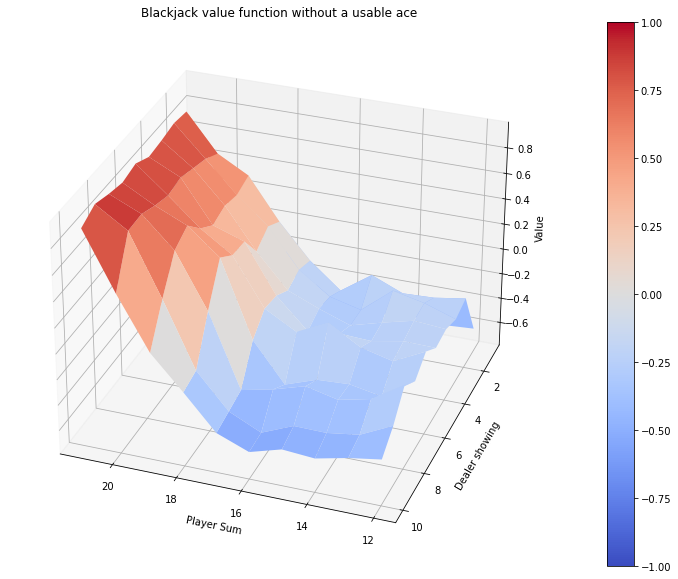

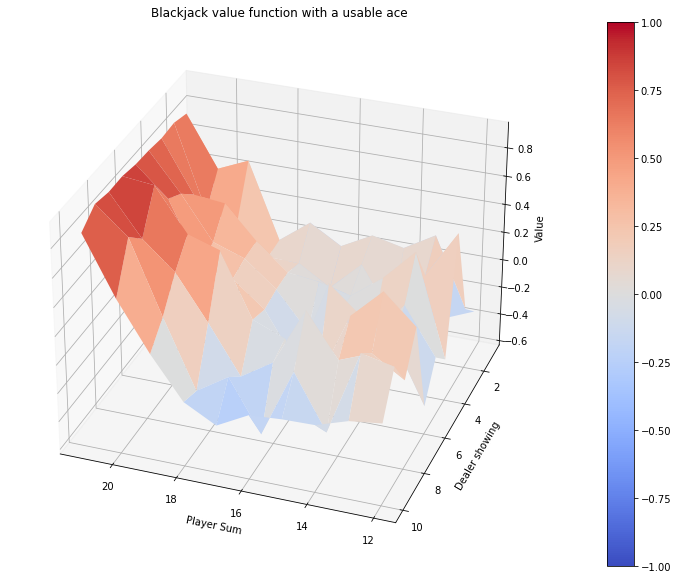

In [25]:
plot_blackjack_values(optimal_value)

# Output graph is very rough due to the low number of episodes. Increasing the number of episdoes to 500,000 results in a much smoother surface.

In [88]:
def simulate_episode(env, policy):
    state = env.reset()
    is_done = False
    while not is_done:
        action = policy[state]
        state, reward, is_done, info = env.step(action)
    return reward


def compare_scores(env, optimal_policy):
    hold_score = 18
    hold_policy = {}
    for player in range(2, 22):
        for dealer in range(1, 11):
            action = 1 if player < hold_score else 0
            for ace in [True, False]:
                hold_policy[(player, dealer, ace)] = action

    num_episodes = 50000
    optimal_scores = [0, 0]
    simple_scores = [0, 0]
    for episode in tqdm(range(num_episodes)):
        reward = simulate_episode(env, optimal_policy)
        if reward == 1:
            optimal_scores[0] += 1
        elif reward == -1:
            optimal_scores[1] += 1
        reward = simulate_episode(env, hold_policy)
        if reward == 1:
            simple_scores[0] += 1
        elif reward == -1:
            simple_scores[1] += 1
    print(f"\nOptimal policy:\nWin rate: {optimal_scores[0] / num_episodes * 100 :.2f}%" 
    f"\tLoss rate: {optimal_scores[1] / num_episodes * 100:.2f}%")
    print(f"Simple policy:\nWin rate: {simple_scores[0] / num_episodes * 100:.2f}%" 
    f"\tLoss rate: {simple_scores[1] / num_episodes * 100:.2f}%")

In [51]:
compare_scores(env, optimal_policy)

Optimal policy:
Win rate: 42.12%	Loss rate: 48.98%
Simple policy:
Win rate: 39.92%	Loss rate: 50.98%


### Epsilon-Greedy MC Control on-policy

In [57]:
def run_eps_episode(env, Q, epsilon, num_actions):
    state = env.reset()
    rewards, actions, states = [], [], []
    is_done = False
    while not is_done:
        proba = torch.ones(num_actions) * epsilon / num_actions      # epsilon-greedy starting probabilities
        best_action = torch.argmax(Q[state]).item()
        proba[best_action] += 1 - epsilon
        action = torch.multinomial(proba, 1).item()                  # Choose 1 action from the multinomial distribution
        actions.append(action)
        states.append(state)
        state, reward, is_done, info = env.step(action)
        rewards.append(reward)
    return states, actions, rewards

In [58]:
def mc_control_eps_greedy(env, gamma, num_episodes, epsilon):
    num_actions = env.action_space.n
    G_sum = defaultdict(float)
    N = defaultdict(int)
    Q = defaultdict(lambda: torch.zeros(num_actions))
    for episode in tqdm(range(num_episodes)):
        states, actions, rewards = run_eps_episode(env, Q, epsilon, num_actions)          
        # only difference in this function 
        return_proba = 0
        G = {}
        for state, action, reward in zip(states[::-1], actions[::-1], rewards[::-1]):        
            # First visit MC policy value prediction
            return_proba = gamma * return_proba + reward
            G[(state, action)] = return_proba
        for (state, action), return_proba in G.items():                                      
            # Update Q function
            if state[0] <= 21:
                G_sum[(state, action)] += return_proba
                N[(state, action)] += 1
                Q[state][action] = G_sum[(state, action)] / N[(state, action)]
        policy = {}
    for state, actions in Q.items():             # Making the policy greedy (less so)
        policy[state] = torch.argmax(actions).item()
    return Q, policy

In [59]:
gamma = 1
epsilon = 0.1
num_episodes = 50000
optimal_Q, optimal_policy = mc_control_eps_greedy(env, gamma, num_episodes, epsilon)

100%|██████████| 50000/50000 [02:26<00:00, 340.89it/s]


In [61]:
compare_scores(env, optimal_policy)
# Generally better results than strictly greedy policy as epsilon encourages exploration

100%|██████████| 50000/50000 [00:13<00:00, 3640.23it/s]Optimal policy:
Win rate: 41.65%	Loss rate: 49.71%
Simple policy:
Win rate: 39.94%	Loss rate: 50.91%



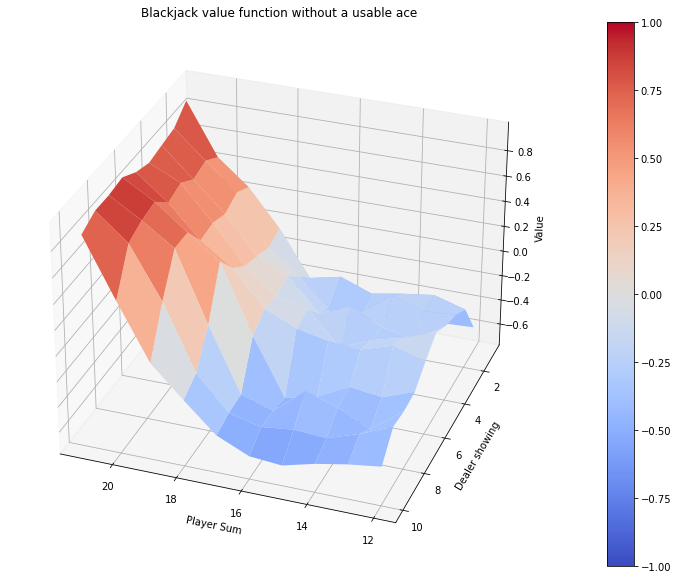

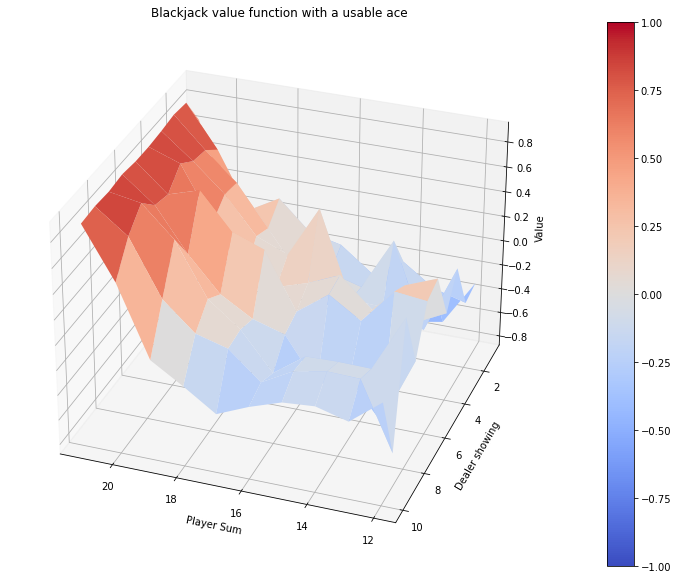

In [62]:
optimal_value = defaultdict(float)
for state, action_values in optimal_Q.items():
    optimal_value[state] = torch.max(action_values).item()
plot_blackjack_values(optimal_value)

### Off policy Monte-Carlo control
Uses two different policy functions: target policy(greedy) and behaviour policy(stochastic, all probabilities greater than 0) to create the optimal policy.

In [70]:
# Behaviour policy

def generate_random_policy(num_actions):
    probs = torch.ones(num_actions) / num_actions           # Doesn't matter, just send the same probabilities for everything(>0)
    def policy_function(state):
        return probs
    return policy_function

def run_episode(env, behaviour_policy):
    state = env.reset()
    rewards, actions, states = [], [], []
    is_done = False
    while not is_done:
        probs = behaviour_policy(state)
        action = torch.multinomial(probs, 1).item()
        actions.append(action)
        states.append(state)
        state, reward, is_done, info = env.step(action)
        rewards.append(reward)
    return states, actions, rewards

In [79]:
def off_policy_mc_control(env, gamma, num_episodes, behaviour_policy):
    num_actions = env.action_space.n
    G_sum = defaultdict(float)
    N = defaultdict(int)
    Q = defaultdict(lambda: torch.zeros(num_actions))
    for episode in tqdm(range(num_episodes)):
        weights = {}
        w = 1
        states, actions, rewards = run_episode(env, behaviour_policy)
        return_proba = 0    
        G = {}
        for state, action, reward in zip(reversed(states), reversed(actions), reversed(rewards)):
            return_proba = gamma * return_proba + reward
            G[(state, action)] = return_proba
            w = w / float(behaviour_policy(state)[action])
            weights[(state, action)] = w
            if action != torch.argmax(Q[state]):                     # Only continue as long as behaviour and target policies match
                break
           
        for state_action, return_proba in G.items():
            state, action = state_action
            if state[0] <= 21:
                G_sum[state_action] += return_proba * weights[state_action]
                N[state_action] += 1
                Q[state][action] = G_sum[state_action] / N[state_action]
    policy = {}
    for state, actions in Q.items():
        policy[state] = torch.argmax(actions).item()
    return Q, policy

In [80]:
gamma = 1
num_episodes = 50000
random_policy = generate_random_policy(env.action_space.n)

optimal_Q, optimal_policy = off_policy_mc_control(env, gamma, num_episodes, random_policy)

100%|██████████| 50000/50000 [00:15<00:00, 3177.62it/s]


In [81]:
compare_scores(env, optimal_policy)

100%|██████████| 50000/50000 [00:12<00:00, 3893.16it/s]Optimal policy:
Win rate: 41.02%	Loss rate: 52.24%
Simple policy:
Win rate: 39.67%	Loss rate: 51.04%



In [86]:
# Incremental update of Q-function, more efficient and scalable
def off_policy_mc_control_incremental(env, gamma, num_episodes, behaviour_policy):
    num_actions = env.action_space.n
    N = defaultdict(int)
    Q = defaultdict(lambda: torch.zeros(num_actions))
    for episode in tqdm(range(num_episodes)):
        w = 1.0
        states, actions, rewards = run_episode(env, behaviour_policy)
        return_proba = 0    
        for state, action, reward in zip(reversed(states), reversed(actions), reversed(rewards)):
            return_proba = gamma * return_proba + reward
            N[(state, action)] += 1
            Q[state][action] += (w / N[(state, action)]) * (return_proba - Q[state][action])   # Incremental update
            if action != torch.argmax(Q[state]).item():
                break
            w = w / behaviour_policy(state)[action]
    policy = {}
    for state, actions in Q.items():
        policy[state] = torch.argmax(actions).item()
    return Q, policy

In [87]:
gamma = 1
num_episodes = 50000
random_policy = generate_random_policy(env.action_space.n)

optimal_Q, optimal_policy = off_policy_mc_control_incremental(env, gamma, num_episodes, random_policy)

compare_scores(env, optimal_policy)

100%|██████████| 50000/50000 [00:11<00:00, 4286.72it/s]Optimal policy:
Win rate: 42.23%	Loss rate: 48.65%
Simple policy:
Win rate: 40.02%	Loss rate: 51.03%



### Off-policy MC control: Weighted Importance Sampling
The previous method used ordinary importance sampling i.e. w/N`[state`]`[action`] in weighing the relative frequencies of actions in the behaviour and target policies. This method has high variance in general (and can be as high as inf). 

A better approach here is weighted importance sampling, which takes the weighted average of returns rather than simple averages.

In [90]:
def off_policy_mc_control_weighted(env, gamma, num_episodes, behaviour_policy):
    num_actions = env.action_space.n
    N = defaultdict(int)
    Q = defaultdict(lambda: torch.zeros(num_actions))
    for episode in tqdm(range(num_episodes)):
        w = 1.0
        states, actions, rewards = run_episode(env, behaviour_policy)
        return_proba = 0    
        for state, action, reward in zip(reversed(states), reversed(actions), reversed(rewards)):
            return_proba = gamma * return_proba + reward
            N[(state, action)] += w                                # MAJOR DIFFERENCE IN THIS LINE ONLY: takes weighted counts
            Q[state][action] += (w / N[(state, action)]) * (return_proba - Q[state][action])   # Incremental update
            if action != torch.argmax(Q[state]).item():
                break
            w = w / behaviour_policy(state)[action]
    policy = {}
    for state, actions in Q.items():
        policy[state] = torch.argmax(actions).item()
    return Q, policy

In [91]:
gamma = 1
num_episodes = 50000
random_policy = generate_random_policy(env.action_space.n)

optimal_Q, optimal_policy = off_policy_mc_control_incremental(env, gamma, num_episodes, random_policy)

compare_scores(env, optimal_policy)

100%|██████████| 50000/50000 [00:14<00:00, 3563.07it/s]
Optimal policy:
Win rate: 42.24%	Loss rate: 48.66%
Simple policy:
Win rate: 40.05%	Loss rate: 50.78%

